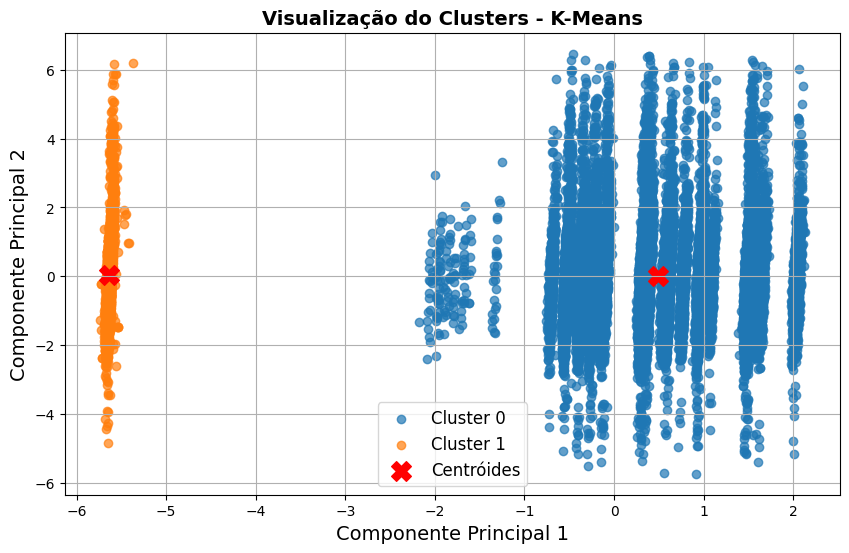


=== Resultados do Modelo de Regressão ===
Mean Absolute Error (MAE): 3.63
Mean Squared Error (MSE): 21.95


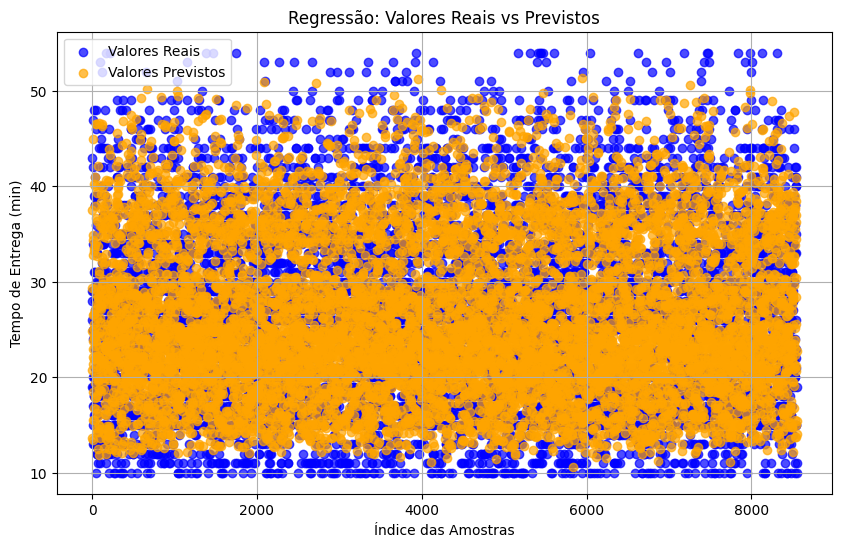


=== Resultados do Modelo de Classificação ===
Accuracy: 0.92

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.81      0.86      2596
           1       0.92      0.97      0.94      5955

    accuracy                           0.92      8551
   macro avg       0.92      0.89      0.90      8551
weighted avg       0.92      0.92      0.92      8551



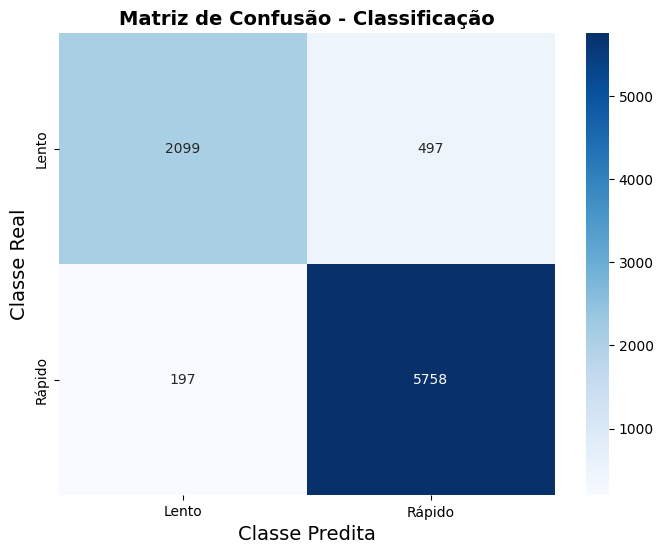

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, mean_absolute_error, mean_squared_error
)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Carregar os dados
file_path = 'train.csv'
data = pd.read_csv(file_path)

# 2. Limpeza dos dados

data_cleaned = data.drop(columns=["ID", "Delivery_person_ID", "Order_Date", "Time_Orderd", "Time_Order_picked"]).copy()

# Limpar a coluna "Time_taken(min)" e converter para numérica
data_cleaned["Time_taken(min)"] = data_cleaned["Time_taken(min)"].str.extract(r"(\d+)").astype(float)

# Converter colunas numéricas que estão como texto
data_cleaned["Delivery_person_Age"] = pd.to_numeric(data_cleaned["Delivery_person_Age"], errors='coerce')
data_cleaned["Delivery_person_Ratings"] = pd.to_numeric(data_cleaned["Delivery_person_Ratings"], errors='coerce')
data_cleaned["multiple_deliveries"] = pd.to_numeric(data_cleaned["multiple_deliveries"], errors='coerce')

# Tratar valores ausentes removendo linhas incompletas
data_cleaned = data_cleaned.dropna().copy()

# Codificar variáveis categóricas
categorical_columns = [
    "Weatherconditions", "Road_traffic_density", "Type_of_order",
    "Type_of_vehicle", "Festival", "City"
]
label_encoders = {col: LabelEncoder() for col in categorical_columns}
for col in categorical_columns:
    data_cleaned.loc[:, col] = label_encoders[col].fit_transform(data_cleaned[col])

# Escalar os dados para K-Means
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_cleaned.drop(columns=["Time_taken(min)"]))

# 3. K-Means
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(scaled_data)

# Adicionar os rótulos dos clusters ao DataFrame
data_cleaned["Cluster"] = kmeans.labels_

# Visualização dos clusters com PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

plt.figure(figsize=(10, 6))
for cluster in range(2):
    cluster_data = reduced_data[kmeans.labels_ == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f"Cluster {cluster}", alpha=0.7)

centroids = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], s=200, c="red", label="Centróides", marker="X")

plt.title("Visualização do Clusters - K-Means", fontsize=14, fontweight='bold')
plt.xlabel("Componente Principal 1", fontsize=14)
plt.ylabel("Componente Principal 2", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# 4. Regressão

X_reg = data_cleaned.drop(columns=["Time_taken(min)", "Cluster"])
y_reg = data_cleaned["Time_taken(min)"]

# Divisão em treino e teste
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Treinar o modelo de regressão
regressor = RandomForestRegressor(random_state=42)
regressor.fit(X_train_reg, y_train_reg)

# Avaliação do modelo de regressão
y_pred_reg = regressor.predict(X_test_reg)
mae = mean_absolute_error(y_test_reg, y_pred_reg)
mse = mean_squared_error(y_test_reg, y_pred_reg)

# Exibição dos resultados de regressão
print("\n=== Resultados do Modelo de Regressão ===")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")

# Comparação gráfica entre valores reais e previstos
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test_reg)), y_test_reg, label='Valores Reais', alpha=0.7, color='blue')
plt.scatter(range(len(y_pred_reg)), y_pred_reg, label='Valores Previstos', alpha=0.7, color='orange')
plt.title("Regressão: Valores Reais vs Previstos")
plt.xlabel("Índice das Amostras")
plt.ylabel("Tempo de Entrega (min)")
plt.legend()
plt.grid(True)
plt.show()


# 5. Classificação
X_clf = data_cleaned.drop(columns=["Time_taken(min)", "Cluster"])
y_clf = data_cleaned["Time_taken(min)"].apply(lambda x: 1 if x <= 30 else 0)  # Rápido (1) ou Lento (0)

# Divisão em treino e teste
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)

# Treinar o modelo de classificação
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train_clf, y_train_clf)

# Avaliação do modelo de classificação
y_pred_clf = classifier.predict(X_test_clf)
accuracy = accuracy_score(y_test_clf, y_pred_clf)
report = classification_report(y_test_clf, y_pred_clf)

print("\n=== Resultados do Modelo de Classificação ===")
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", report)

# Matriz de Confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Lento", "Rápido"], yticklabels=["Lento", "Rápido"])
plt.title('Matriz de Confusão - Classificação', fontsize=14, fontweight='bold')
plt.xlabel('Classe Predita', fontsize=14)
plt.ylabel('Classe Real', fontsize=14)
plt.show()
